## 목적: 인사평가 데이터 (x 값: 팀장이 해당등급을 준 이유(텍스트) y 값: A~C등급)를 활용한 평가 예측 후, 미스매치 등 잡아내기
## Goal: Predict based on Annual Evaluation Data (x: Reasons why director gave this grade (text) y: A ~ C grade) and catch falsified evaluation (mismatch between text and grade)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Twitter
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [ ]:
## 이미지에 한글폰트 안읽힐때 설정하는법
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family=font_name)

In [ ]:
## df에서 특정 두개 컬럼 값 비교하여 모든 row 값 빠르게 추출 (for loop 안쓰고 빠르게하는법)
def Mismatch(row):
    if row['grade']!=row['Pred']:
        __temp='Y'
    else:
        __temp='N'
    return __temp

In [ ]:
def data_pos_array(_sentence_array,_stopwords):
    twt=Twitter()
    _array1=[] ## 문장에서 해당, 품사만 걸러낸 것 ex "기여 개발 프로젝트"
    _array2=[] ## 문장에 포함된 품사들의 리스트 ex ["기여", "개발", "프로젝트"]
    for sentence in _sentence_array:
        _pos=twt.pos(sentence, stem=True)
        _NVA=[word[0] for word in _pos if word[1]=='Verb' or word[1]=='Noun' or word[1]=='Adjective' or word[1]=='Josa' or word[1]=='Conjunction' or word[1]=='Adverb' if not word[0] in _stopwords]
        _temp=''
        for i in _NVA:
            _temp+=i
            _temp+=' '
        _array1.append(_temp)
        _array2.append(_NVA)
    return _array1, _array2

In [ ]:
## 단어와 tfidf 값과 인사평가등급이 있는 인풋을 받아서, 등급별 분류 후, A와 C에서 주로 쓰는 단어들을 추출

def get_adj_AClist(_tfidf_pd, _n):
    _txt=_tfidf_pd.columns[:-1]
    _numgrade=_tfidf_pd.groupby('grade').size().reset_index(name='count')
    _Anum=_numgrade[_numgrade['grade']=='A']['count'][0]
    _Bnum=_numgrade[_numgrade['grade']=='B']['count'][1]
    _Cnum=_numgrade[_numgrade['grade']=='C']['count'][2]
    _Atfidfdict=dict(np.sum(_tfidf_pd[_tfidf_pd['grade']=='A'][_txt]))
    _Btfidfdict=dict(np.sum(_tfidf_pd[_tfidf_pd['grade']=='B'][_txt]))
    _Ctfidfdict=dict(np.sum(_tfidf_pd[_tfidf_pd['grade']=='C'][_txt]))
    _sorttfidfA=sorted(_Atfidfdict.items(),key=lambda item:item[1],reverse=True)
    _percentfidfA=[(i[0],i[1]/_Anum) for i in _sorttfidfA]
    _sorttfidfB=sorted(_Btfidfdict.items(),key=lambda item:item[1],reverse=True)
    _percentfidfB=[(i[0],i[1]/_Bnum) for i in _sorttfidfB]
    _sorttfidfC=sorted(_Ctfidfdict.items(),key=lambda item:item[1],reverse=True)
    _percentfidfC=[(i[0],i[1]/_Cnum) for i in _sorttfidfC]
    
    adj_tfidf_dictA=[]
    adj_tfidf_dictB=[]
    adj_tfidf_dictC=[]
    for i in list(_Atfidfdict.keys()):
        _tempA=dict(_percentfidfA)[i]
        _tempB=dict(_percentfidfB)[i]
        _tempC=dict(_percentfidfC)[i]
        adj_tfidf_dictA.append((i,_tempA-np.min([_tempA,_tempB,_tempC])))
        adj_tfidf_dictB.append((i,_tempB-np.min([_tempA,_tempB,_tempC])))
        adj_tfidf_dictC.append((i,_tempC-np.min([_tempA,_tempB,_tempC])))
    
    _srtA=dict(sorted(dict(adj_tfidf_dictA).items(),key=lambda item:item[1],reverse=True))
    _srtB=dict(sorted(dict(adj_tfidf_dictB).items(),key=lambda item:item[1],reverse=True))
    _srtC=dict(sorted(dict(adj_tfidf_dictC).items(),key=lambda item:item[1],reverse=True))
    
    adjtfidfA_pd=pd.DataFrame(list(_srtA.items()),columns=['words','adjTFIDF'])
    adjtfidfB_pd=pd.DataFrame(list(_srtB.items()),columns=['words','adjTFIDF'])
    adjtfidfC_pd=pd.DataFrame(list(_srtC.items()),columns=['words','adjTFIDF'])
    n_tfidf=_n
    
    adj_AClist=[]
    adj_Alist=list(_srtA.keys())[:n_tfidf]
    adj_Clist=list(_srtC.keys())[:n_tfidf]
    for i in range(len(adj_Alist)):
        if list(_srtA.values())[i]!=0:
            adj_AClist.append(adj_Alist[i])
        if list(_srtC.values())[i]!=0:
            adj_AClist.append(adj_Clist[i])
    adj_AClist=np.unique(adj_AClist)
    
    return adj_AClist, adjtfidfA_pd, adjtfidfB_pd, adjtfidfC_pd

In [ ]:
from wordcloud import (WordCloud, get_single_color_func)

class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color={word: color for (color,words) in color_to_words.items() for word in words}
        self.default_color=default_color
        
    def __call__(self,word,**kwargs):
        return self.word_to_color.get(word,self.default_color)
    
class GroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.color_func_to_words=[(get_single_color_func(color),set(words)) for (color,words) in color_to_words.items()]
        self.default_color_func=get_single_color_func(default_color)
        
    def get_color_func(self,word):
        try:
            color_func=next(color_func for (color_func,words) in self.color_func_to_words if word in words)
        except StopIteration:
            color_func=self.default_color_func
        
        return color_func

    def __call__(self,word,**kwargs):
        return self.get_color_func(word)(word,**kwargs)

## DATA PREPROCESSING(16-18)

In [ ]:
_raw1=pd.read_csv('./data/input/2016pm_1.csv',encoding='cp949')
_raw2=pd.read_csv('./data/input/2017pm_1.csv',encoding='cp949')
_raw3=pd.read_csv('./data/input/2018pm_1.csv',encoding='cp949')

In [ ]:
_data1=_raw1[['종합의견상사평가(역량)','역량등급']]
_data2=_raw2[['종합의견상사평가(역량)','역량등급']]
_data3=_raw3[['종합의견(상사)','등급']]

_colname=['raw','grade']

_data1.columns=_colname
_data2.columns=_colname
_data3.columns=_colname

_data1618=pd.concat([_data1[['raw','grade']],_data2[['raw','grade']],_data3[['raw','grade']]]).reset_index(drop=True)
_data1618['X']=_data1618['raw'].str.replace("[^ㄱ-하-ㅣ 가-힣]","") ## 모든 한글만 남고 띄어쓰기 다 없어짐
_data1618=_data1618.dropna(how='any')
_data1618=_data1618.reset_index(drop=True)

In [ ]:
_numgrade=_data1618.groupby('grade').size().reset_index(name='count')
_Anum=_numgrade[_numgrade['grade']=='A']['count'][0]
_Bnum=_numgrade[_numgrade['grade']=='B']['count'][1]
_Cnum=_numgrade[_numgrade['grade']=='C']['count'][2]

In [ ]:
_numgrade

In [ ]:
# 이미지 1
_data1618.head()

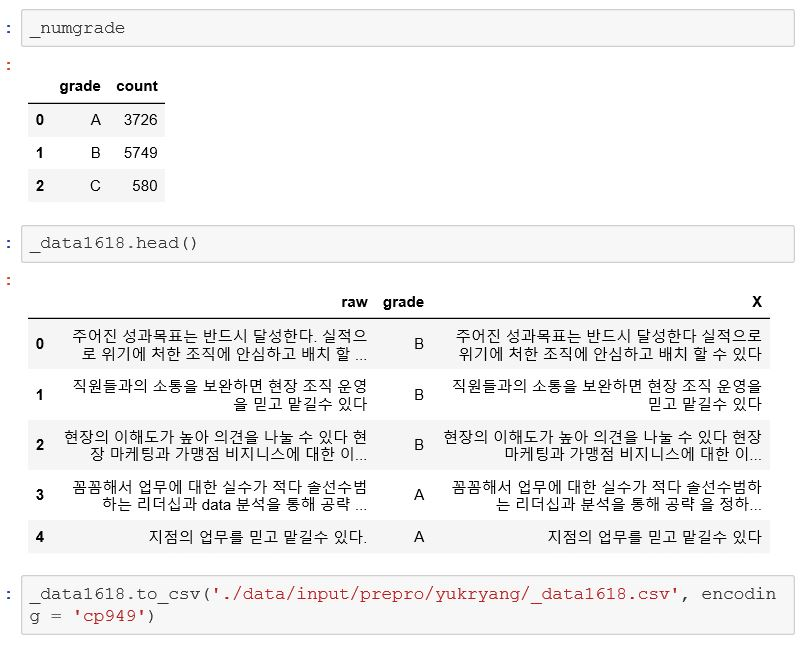

In [ ]:
_data1618.to_csv('_data1618.csv',encoding='cp949')

## 19년도
## 2019 Data

In [ ]:
_data19=pd.read_csv('2019pm_1.csv',encoding='cp949')
_data19=_data19[['상사종합의견기술','승인등급']]
_colname=['raw','grade']
_data19.columns=_colname
_data19['X']=_data19['raw'].str.replace("[^ㄱ-ㅎㅏ-ㅣ 가-힣]","")
_data19=_data19.dropna(how='any')
_data19=_data19.reset_index(drop=True)

In [ ]:
# 이미지 2
_data19.groupby('grade').size()

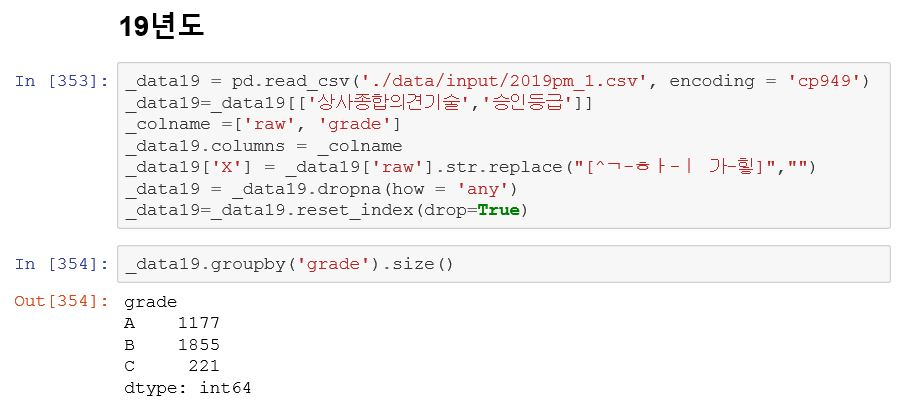

In [ ]:
_data19.to_csv('_data19.csv',encoding='cp949')

## TFIDF

In [ ]:
_data1618=pd.read_csv('_data1618.csv',encodig='cp949',index_col=0)
_data19=pd.read_csv('_data19.csv',encoding='cp949',index_col=0)

In [ ]:
_stopwords1=['하다','업무','있다']
_1618array1, _1618array2=data_pos_array(_data1618['X'],_stopwords1)
_19array1, _19array2=data_pos_array(_data19['X'],_stopwords1)

In [ ]:
_tf_vec=TfidfVectorizer(max_features=200,max_df=0.95,min_df=0)
_tf_fit=_tf_vec.fit_transform(_1618array1)
_tf_txt=_tf_vec.get_feature_names()

####1618
_count_vec=Countvectorizer(min_df=1)
_count_fit=_count_vec.fit_transform(_1618array1)
_count_txt=_count_vec.get_feature_names()

####19
_count_vec19=CountVectorizer(min_df=1)
_count_fit19=_count_vec.fit_transform(_19array1)   ## 단어별 카운트된 matrix (컬럼 수=단어 수, row 수=input data row 수)
_count_txt19=_count_vec19.get_feature_names()

_count_pd_1618=pd.DataFrame(_count_fit.toarray(),columns=_count_txt)
_count_pd_19=pd.DataFrame(_count_fit.toarray(),columns=_count_txt)

In [ ]:
_count_pd_1618.to_csv('_count_pd_1618.csv',encoding='cp949')
_count_pd_19.to_csv('_count_pd_19.csv',encoding='cp949')

In [ ]:
_tfidf_pd_1618=_count_pd_1618[_tf_txt] ## 1618년도 전체 단어별 카운트 매트릭스에서 tfidf 단어들만 추림
_tfidf_pd_1618['grade']=_data1618['grade']

In [ ]:
# 이미지 3
_adj_AClist,adjtfidfA_pd,_,_adjtfidfC_pd=get_adj_AClist(_tfidf_pd_1618,50)
print('고려하는 단어의 수:',len(_adj_AClist))
print('고려하는 단어 ',_adj_AClist)

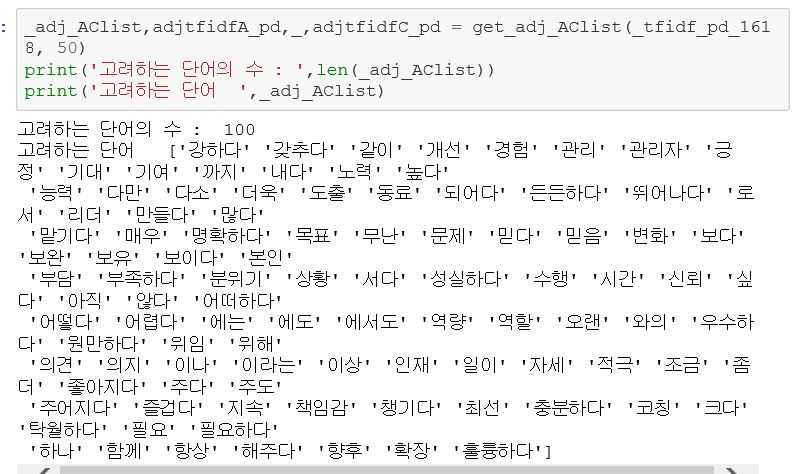

In [ ]:
def word_count(_wordvec,_adj_tfidflist):
    _temp=[]
    for j in _wordvec:
        _ttemp={}
        for k in j:
            if k in _adj_tfidflist:
                _idx=np.where(np.array(j)==k)[0]
                _ttemp[k]=len(_idx)
        _temp.append(_ttemp)
    return _temp

In [ ]:
# 이미지 4
_tfidf_pd_1618=_tfidf_pd_1618[_adj_AClist]
_tfidf_pd_1618['grade']=_data1618['grade']
_tfidf_pd_1618['raw']=_data1618['raw']
_tfidf_pd_1618['count_dict']=word_count(_1618array2,_adj_AClist)
_tfidf_pd_1618.head()

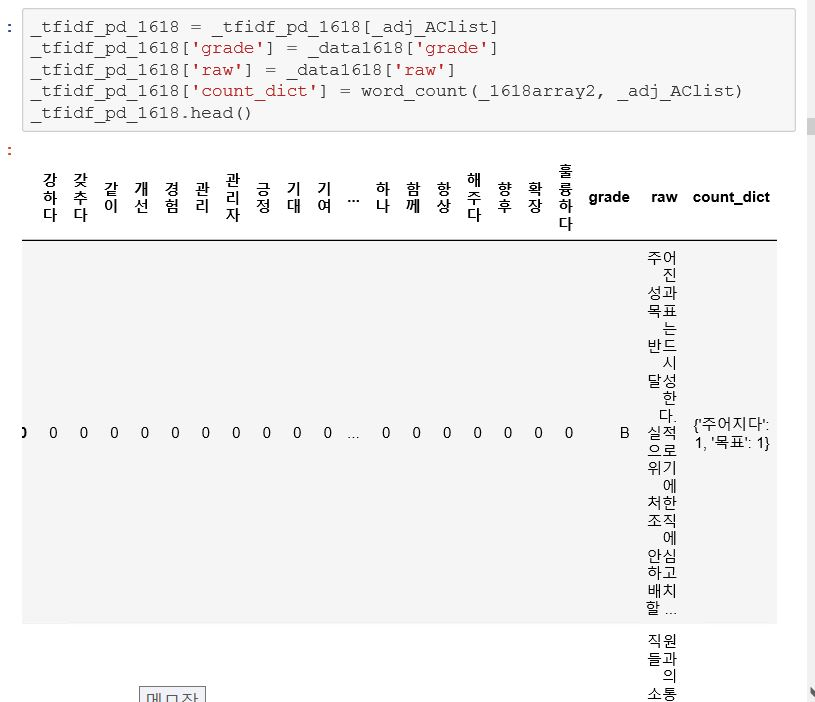

In [ ]:
_tfidf_pd_19=_count_pd_19[_adj_AClist]
_tfidf_pd_19['grade']=_data19['grade']
_tfidf_pd_19['raw']=_data19['raw']
_tfidf_pd_19['count_dict']=word_count(_19array2,_adj_AClist)
_tfidf_pd_19.head()

In [ ]:
_tfidf_pd_1618.to_csv('_tfidf_pd_1618.csv',encoding='cp949')
_tfidf_pd_19.to_csv('_tfidf_pd_19.csv',encoding='cp949')

In [ ]:
tfidf_sum=np.sum(_tfidf_pd_19,axis=1)
_del_list=list(tfidf_sum[tfidf_sum==0].index)
_not_del_list=list(tfidf_sum[tfidf_sum!=0].index)

_data19_0=_data19.loc[_del_list]
_data19_0[['raw','grade']].to_csv('무성의평가_역량.csv',encoding='cp949')

## Modeling

In [ ]:
_tfidf_pd_1618=pd.read_csv('_tfidf_pd_1618.csv',encoding='cp949',index_col=0)
_tfidf_pd_19=pd.read_csv('_tfidf_pd_19.csv',encoding='cp949',index_col=0)

In [ ]:
del_list1618=_tfidf_pd_1618[np.sum(_tfidf_pd_1618,axis=1)==0].index
_data_1618_n=_data1618.drop(del_list1618).reset_index(drop=True)
_tfidf_pd_1618_n=_tfidf_pd_1618.drop(del_list1618).reset_index(drop=True)

del_list19=_tfidf_pd_19[np.sum(_tfidf_pd_19,axis=1)==0].index
_data_19_n=_data19.drop(del_list19).reset_index(drop=True)
_tfidf_pd_19_n=_tfidf_pd_19.drop(del_list19).reset_index(drop=True)


In [ ]:
### A,C만 남기기
_tfidf_pd_1618_AC=_tfidf_pd_1618_n[_tfidf_pd_1618_n['grade']!='B']
_tfidf_pd_1618_AC=_tfidf_pd_1618_AC.reset_index(drop=True)
_tfidf_pd_1618_AC['int_grade']=_tfidf_pd_1618_AC['grade'].apply(lambda x:0 if x=='C' else 1)

In [ ]:
### A,C만 남기기
_tfidf_pd_19_AC=_tfidf_pd_19_n[_tfidf_pd_19_n['grade']!='B']
_tfidf_pd_19_AC=_tfidf_pd_19_AC.reset_index(drop=True)
_tfidf_pd_19_AC['int_grade']=_tfidf_pd_19_AC['grade'].apply(lambda x:0 if x=='C' else 1)

In [ ]:
### random forest
X_raw=_tfidf_pd_1618_AC[_tfidf_pd_1618_AC.columns[:-4]]
Y_raw=_tfidf_pd_1618_AC['int_grade']

X_test=_tfidf_pd_19_AC[_tfidf_pd_19_AC.columns[:-4]]
Y_test=_tfidf_pd_19_AC['int_grade']

In [ ]:
#### 이미지 5~8

n_iter=5

valid_ratio=0.3

depth_list=[5,10,15,20,30,40,50,75,100,150]
treeN_list=[5,10,15,20,30,40,50,75,100,150]

parameter_result_tr=np.zeros(((n_iter,len(depth_list),len(treeN_list))))
parameter_result_valid=np.zeros(((n_iter,len(depth_list),len(treeN_list))))
parameter_result_Ccorrectratio_tr=np.zeros(((n_iter,len(depth_list),len(treeN_list))))
parameter_result_Ccorrectratio_valid=np.zeros(((n_iter,len(depth_list),len(treeN_list))))

for _iter in range(n_iter):
    rand_seed=np.random.permutation(len(X_raw))
    X_raw_tr=X_raw.loc[rand_seed[:-int(len(X_raw)*valid_ratio)]]
    Y_raw_tr=Y_raw.loc[rand_seed[:-int(len(X_raw)*valid_ratio)]]
    
    X_raw_valid=X_raw.loc[rand_seed[-int(len(X_raw)*valid_ratio):]].reset_index(drop=True)
    Y_raw_valid=Y_raw.loc[rand_seed[-int(len(X_raw)*valid_ratio):]].reset_index(drop=True)
    
    ### Training Set 중 C 복제 (나중에 bootstrap으로 바꿔야함)
    dup_N=2
    if dup_N!=0:
        if _iter==0:
            print('raw_data A/C ratio',len(Y_raw_tr[Y_raw_tr==1])/len(Y_raw_tr),len(Y_raw_tr[Y_raw_tr==0])/len(Y_raw_tr))
        for i in range(dup_N):
            X_raw_tr=X_raw_tr.append(X_raw_tr[Y_raw_tr==0].reset_index(drop=True)).reset_index(drop=True)
            Y_raw_tr=Y_raw_tr.append(Y_raw_tr[Y_raw_tr==0].reset_index(drop=True)).reset_index(drop=True)
            
        if _iter==0:
            print('A/C ratio',len(Y_raw_tr[Y_raw_tr==1])/len(Y_raw_tr),len(Y_raw_tr[Y_raw_tr==0])/len(Y_raw_tr))
            
        ####
        
    for i,depth in enumerate(depth_list):
        for j,treeN in enumerate(treeN_list):
            rf=RandomForestClassifier(max_depth=depth,n_estimators=treeN)
            rf.fit(np.array(X_raw_tr),np.array(Y_raw_tr));

            pred_tr=rf.predict(np.array(X_raw_tr)).reshape(-1,1)
            pred_valid=rf.predict(np.array(X_raw_valid)).reshape(-1,1)

            parameter_result_tr[_iter,i,j]=accuracy_score(pred_tr,np.array(Y_raw_tr))
            parameter_result_valid[_iter,i,j]=accuracy_score(pred_valid,np.array(Y_raw_valid))

            Y_C_tr=len(Y_raw_tr[Y_raw_tr==0])
            Y_C_True_tr=len(np.intersectld(Y_raw_tr[Y_raw_tr==0].index,np.where(pred_tr.reshape(-1)==0)))

            Y_C_valid=len(Y_raw_valid[Y_raw_valid==0])
            Y_C_True_valid=len(np.intersectld(Y_raw_valid[Y_raw_valid==0].index,np.where(pred_valid.reshape(-1)==0)))

            parameter_result_Ccoorectratio_tr[_iter,i,j]=Y_C_True_tr/Y_C_tr
            parameter_result_Ccoorectratio_valid[_iter,i,j]=Y_C_True_valid/Y_C_valid

print(np.max(np.mean(parameter_result_tr,axis=0)),np.where(np.mean(parameter_result_tr,axis=0)==np.max(np.mean(parameter_result_tr,axis=0))))
display(pd.DataFrame(np.mean(parameter_result_tr,axis=0),columns=treeN_list,index=depth_list))

print(np.max(np.mean(parameter_result_Ccorrectratio_tr,axis=0)),np.where(np.mean(parameter_result_tr,axis=0)==np.max(np.mean(parameter_result_Ccorrectratio_tr,axis=0))))
display(pd.DataFrame(np.mean(parameter_result_Ccorrectratio_tr,axis=0),columns=treeN_list,index=depth_list))

print(np.max(np.mean(parameter_result_Ccorrectratio_valid,axis=0)),np.where(np.mean(parameter_result_Ccorrectratio_valid,axis=0)==np.max(np.mean(parameter_result_Ccorrectratio_valid,axis=0))))
display(pd.DataFrame(np.mean(parameter_result_Ccorrectratio_valid,axis=0),columns=treeN_list,index=depth_list))

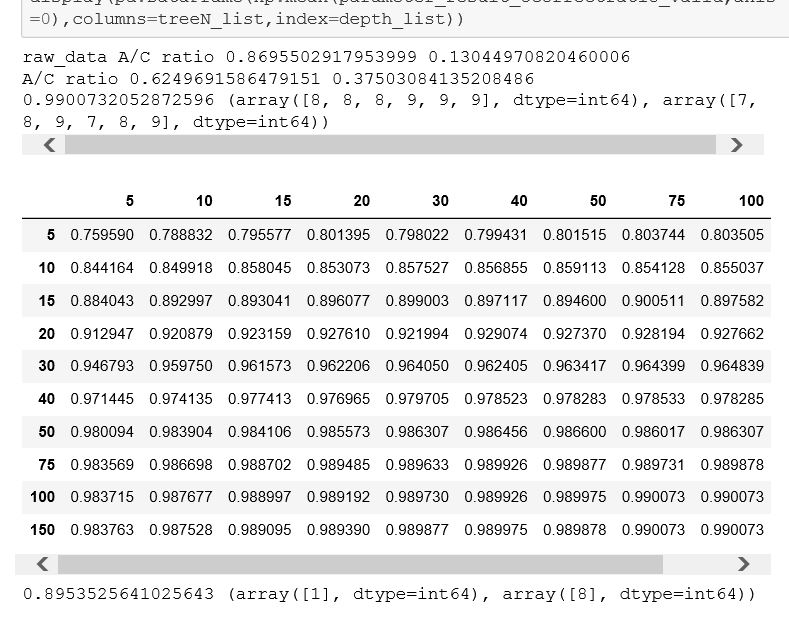

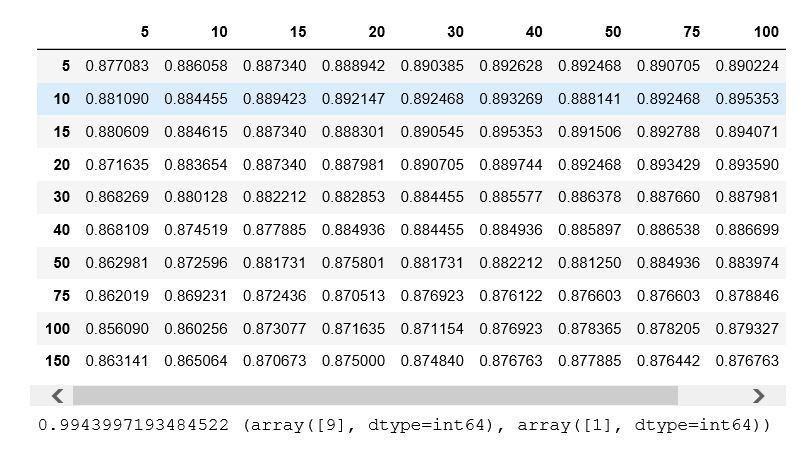

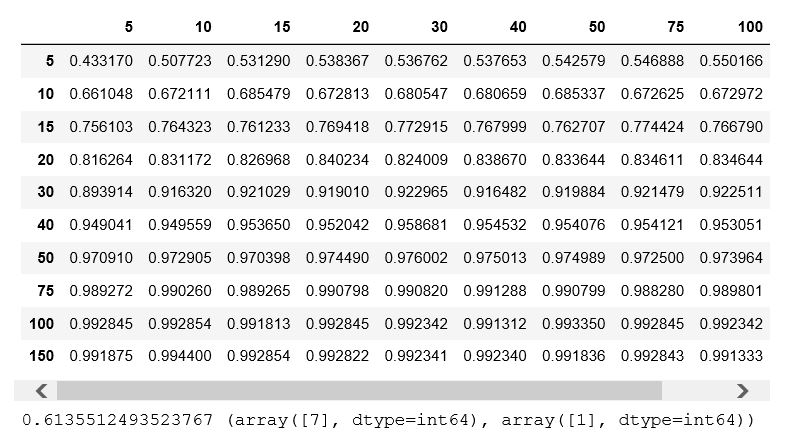

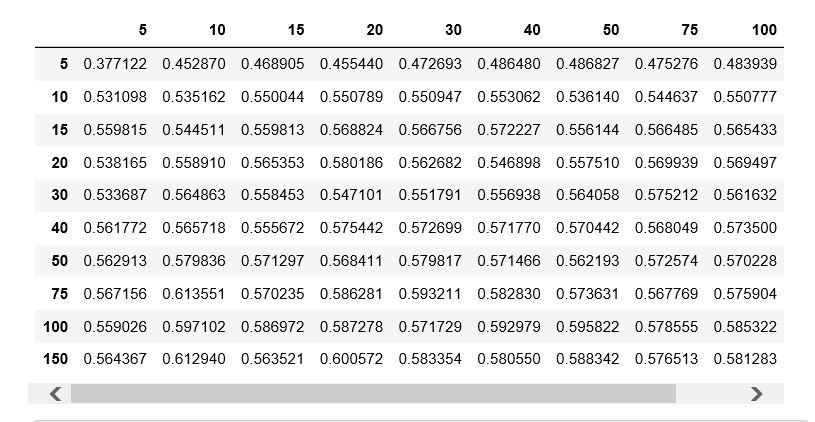

In [ ]:
## 이미지 9

best_depth=depth_list[np.squeeze(np.where(np.mean(parameter_result_Ccorrectratio_valid,axis=0)==np.max(np.mean(parameter_result_Ccorrectratio_valid,axis=0))))[0]]
best_treeN=treeN_list[np.squeeze(np.where(np.mean(parameter_result_Ccorrectratio_valid,axis=0)==np.max(np.mean(parameter_result_Ccorrectratio_valid,axis=0))))[1]]
rand_seed=np.random.permutation(len(X_raw))

X_raw_tr=X_raw.loc[rand_seed[:-int(len(X_raw)*valid_ratio)]]
Y_raw_tr=Y_raw.loc[rand_seed[:-int(len(X_raw)*valid_ratio)]]

X_raw_valid=X_raw.loc[rand_seed[:-int(len(X_raw)*valid_ratio):]].reset_index(drop=True)
Y_raw_valid=Y_raw.loc[rand_seed[:-int(len(X_raw)*valid_ratio):]].reset_index(drop=True)

## C-class ff

dup_N=1
print('raw_data A/C ratio', len(Y_raw_tr[Y_raw_tr==1])/len(Y_raw_tr),len(Y_raw_tr[Y_raw_tr==0])/len(Y_raw_tr))
for i in range(dup_N):
    X_raw_tr=X_raw_tr.append(X_raw_tr[Y_raw_tr==0].reset_index(drop=True)).reset_index(drop=True)
    Y_raw_tr=Y_raw_tr.append(Y_raw_tr[Y_raw_tr==0].reset_index(drop=True)).reset_index(drop=True)
    
    print('A/C ratio',len(Y_raw_tr[Y_raw_tr==1])/len(Y_raw_tr),len(Y_raw_tr[Y_raw_tr==0])/len(Y_raw_tr))
    
rf=RandomForestClassifier(max_depth=50,n_estimators=50)
rf.fit(np.array(X_raw_tr),np.array(Y_raw_tr));

pred_tr=rf.predict(np.array(X_raw_tr)).reshape(-1,1)
pred_valid=rf.predict(np.array(X_raw_valid)).reshape(-1,1)
pred_test=rf.predict(np.array(X_test)).reshape(-1,1)
pred_prob=rf.predict_proba(np.array(X_test))

print('Training Set 성능')
print('오답 샘플: %d'%(Y_raw_tr !=pred_tr.reshape(-1)).sum())
print("accuracy: %.2f" %accuracy_score(Y_raw_tr,pred_tr))
print(confusion_matrix(Y_raw_tr,pred_tr))

print('Validation Set 성능')
print('오답 샘플: %d'%(Y_raw_valid !=pred_valid.reshape(-1)).sum())
print("accuracy: %.2f" %accuracy_score(Y_raw_valid,pred_valid))
print(confusion_matrix(Y_raw_valid,pred_valid))

print('Training Set 성능')
print('오답 샘플: %d'%(Y_test !=pred_test.reshape(-1)).sum())
print("accuracy: %.2f" %accuracy_score(Y_test,pred_test))
print(confusion_matrix(Y_test,pred_test))


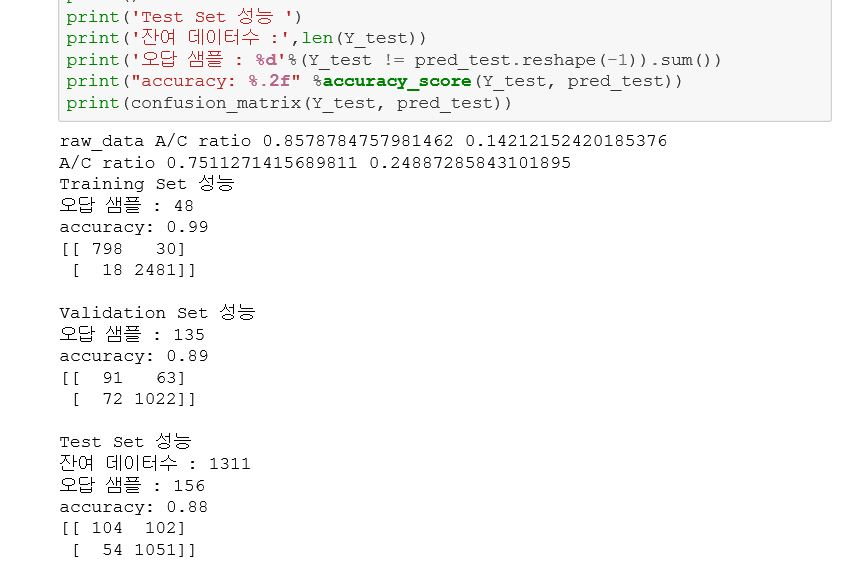

In [ ]:
_rf_result=pd.DataFrame(index=['데이터 수','오답 샘플 수','정확도','CFM','etc'],columns=['Training','Validation','Test'])

In [ ]:
_rf_result.loc['데이터 수']['Training']=len(Y_raw_tr)
_rf_result.loc['데이터 수']['Validation']=len(Y_raw_validation)
_rf_result.loc['데이터 수']['Test']=len(Y_test)

_rf_result.loc['오답 샘플 수']['Training']=(Y_raw_tr!=pred_tr.reshape(-1)).sum()
_rf_result.loc['오답 샘플 수']['Validation']=(Y_raw_valid!=pred_valid.reshape(-1)).sum()
_rf_result.loc['오답 샘플 수']['Test']=(Y_test!=pred_test.reshape(-1)).sum()

_rf_result.loc['정확도']['Training']=accuracy_score(Y_raw_tr,pred_tr)
_rf_result.loc['정확도']['Validation']=accuracy_score(Y_raw_valid,pred_valid)
_rf_result.loc['정확도']['Test']=accuracy_score(Y_test,pred_test)

_rf_result.loc['CFM']['Training']=confusion_matrix(Y_raw_tr,pred_tr)
_rf_result.loc['CFM']['Validation']=confusion_matrix(Y_raw_valid,pred_valid)
_rf_result.loc['CFM']['Test']=confusion_matrix(Y_test,pred_test)

_rf_result.loc['etc']['Traning']=rf.get_params()

In [ ]:
## 이미지 10

_rf_result

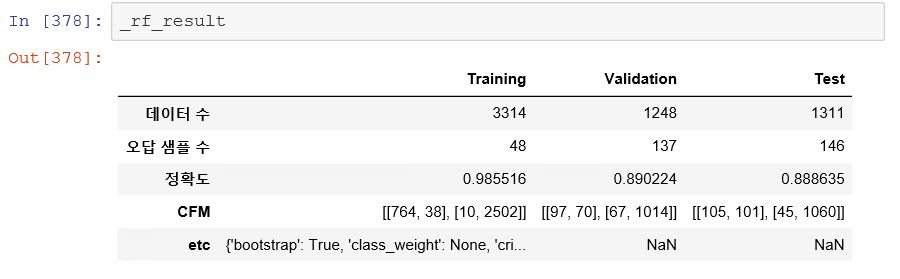

In [ ]:
_rf_result.to_csv('rf_result_역량.csv',encoding='cp949')

In [ ]:
_test_result=_tfidf_pd_19_AC[['raw','count_dict','grade']]
pred_grade=[]
for i in pred_test:
    if i==1:
        pred_grade.append('A')
    else:
        pred_grade.append('C')

_test_result['pred']=pred_grade
_test_result['prob']=np.max(pred_prob,axis=1)
_test_result['Mismatch']=_test_result.appy(Mistmatch,axis=1)

_test_result[_test_result['Mistmatch']=='Y'].to_csv('mismatch_역량_19.csv',encoding='cp949')

In [ ]:
_test_result.to_csv('result_all_역량_19.csv',encoding='cp949')

## Feature Importance

In [ ]:
_FI={}
for i,ii in enumerate(_tf_txt):
    _FI[ii]=rf.feature_importances_[i]
_srtFI=dict(sorted(dict(_FI).items(),key=lambda item:item[1],reverse=False))

In [ ]:
## 이미지 12

fig=plt.figure(figsize=(40,30))
index=np.arange(len(list(_srtFI.keys())))
plt.barh(index, list(dict(_srtFI).values()),align='center')
plt.yticks(index,list(_srtFI.keys()))
plt.tight_layout()
plt.show()

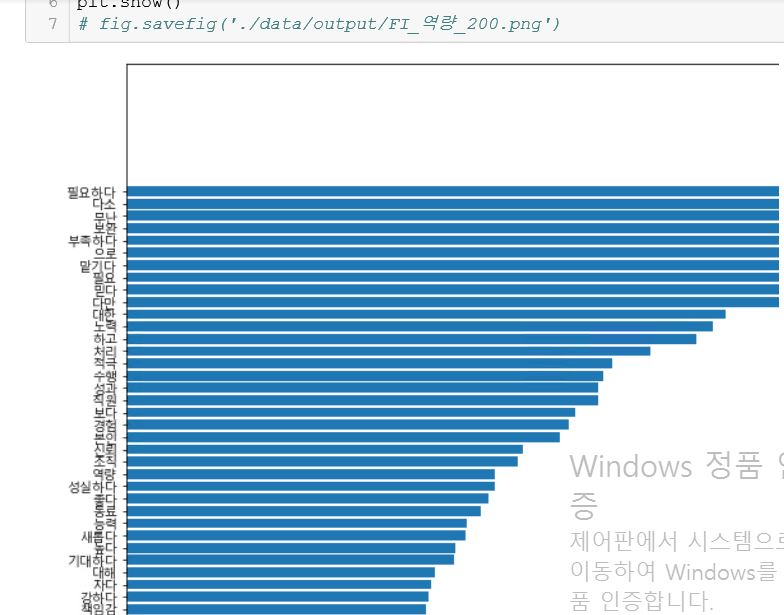

## Word Cloud

In [ ]:
##### 19년 데이터 워드클라우드용으로 19년 데이터로 tfidf 추출
_tf_vec19=TfidfVectorizer(max_features=200,max_df=0.95,min_df=0)
_tf_fit19=_tf_vec19.fit_transform(_19array1)
_tf_txt19=_tf_vec19.get_feature_names()
wc_tfidf_pd_19=_count_pd_19[_tf_txt19]
wc_tfidf_pd_19['grade']=_data19['grade']

_,wc_adjtfidfA_pd19,_,wc_adjtfidfC_pd19=get_adj_AClist(wc_tfidf_pd_19,50)

In [ ]:
### 이미지 11

wc_list=[wc_adjtfidfA_pd19,wc_adjtfidfC_pd19]
color_code=['blue','red']

top_n=50
wc=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800,height=800,background_color='white')

for i in range(len(wc_list)):
    tfidf_dict={}
    color_to_words={}
    
    temp_words_high=[]
    temp_words_low=[]
    for j in range(top_n):
        if j < top_n/2:
            tfidf_dict[wc_list[i]]['words'][[j]]=wc_list[i]['adjTFIDF'][j]
            temp_words_high.append(wc_list[i]['words'][j])
        else:
            tfidf_dict[wc_list[i]]['words'][[j]]=wc_list[i]['adjTFIDF'][j]
            temp_words_low.append(wc_list[i]['words'][j])
            
    color_to_words[color_code[i]]=temp_words_high
    color_to_words['grey']=temp_words_low
    
    wc=wc.generate_from_frequencies(tfidf_dict)
    
    default_color='grey'
    
    #color style1
    simple_color_func=SimpleGroupedColorFunc(color_to_words,default_color)
    wc.recolor(color_func=simple_color_func)
    
#     #color style2
#     grouped_color_func=GroupedColorFunct(color_to_words,default_color)
#     wc.recolor(color_func=grouped_color_func)
    
    wc_array=wc.to_array()
    
    fig=plt.figure(figsize=(10,10))
    plt.imshow(wc_array,interpolation='bilinear')
    plt.axis('off')
    
    if i%2==0:
        fig.savefig('wordcloud_역량A.png')
    else:
        fig.savefig('wordcloud_역량C.png')
    

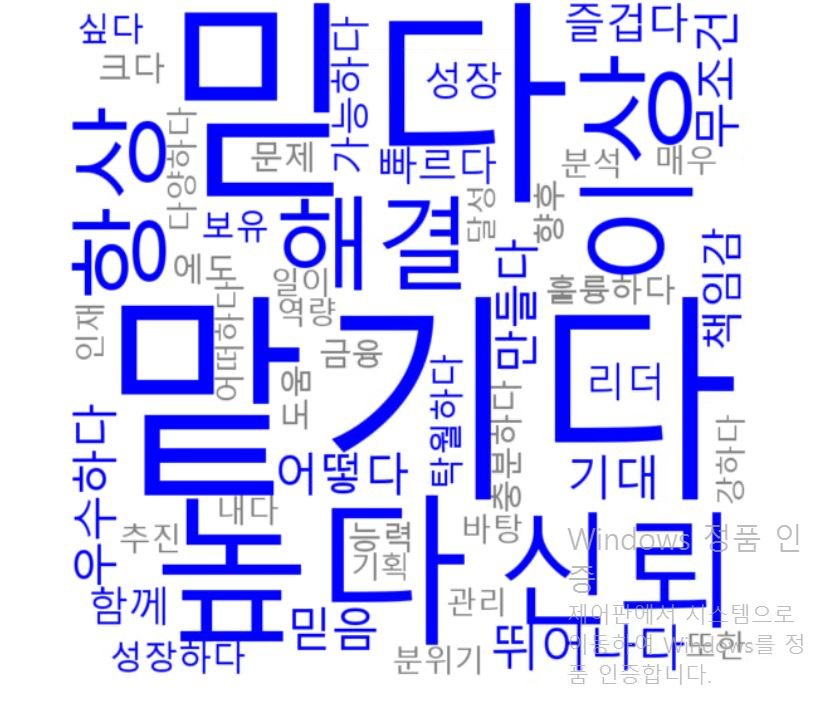